# <a id='toc1_'></a>[This is the shortest verison of DMA, just want to show](#toc0_)

In [1]:
# This is only here to direct python to find where the 
# Mark Ruihe change 
import sys  ; import pybamm; import os
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\\Niall_DMA\\Data Analysis Functions"))
sys.path.append(str_path_1) 

import warnings
warnings.simplefilter('ignore', FutureWarning)

# Standard python libraries required for this to work
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from matplotlib.lines import Line2D
import numpy as np
from scipy import optimize

# Some modules I wrote which contain functions used for data processing/analysis
import NDK_functions_Biologic_loading as bl
import NDK_functions_Degradation_Modes as dm
import NDK_functions_Degradation_Modes_composites as dmc

# To graph the results within the Notebook
# %matplotlib notebook

In [2]:
# Load reference 1/2 cell datasets for each electrode/component (1 for PE, 2 for NE)
PE_OCV = pd.read_csv(
    'Example Data/Reference half-cell data/LGM50_NMC_PE_lithiation_OCV_v2.csv', 
    index_col=0)
NE_LGM50_OCV = pd.read_csv(
    'Example Data/Reference half-cell data/LGM50_SiGr_NE_delithiation_OCV.csv', 
    index_col=0)
NE_Gr_OCV = pd.read_csv(
    'Example Data/Reference half-cell data/Gr_NE_OCV_delithiation.csv', 
    index_col=0)
NE_Si_OCV = pd.read_csv(
    'Example Data/Reference half-cell data/Si_NE_OCV_delithiation_NEW(pure-Si(100mV)cycle2).csv', 
    index_col=0)

In [3]:
# Load full cell datasets to be analysed (a BoL dataset and some aged cell datasets)
AgeDataPath = "D:/OneDrive - Imperial College London/Degradation Tests/"
Path_Exp   = "Expt 3 - Cathode Degradation and Li-Plating/Performance Checks/"
import traceback
Rig_Exp3 = {
    "A":"1","B":"1","C":"1",
    "D":"3","E":"3","F":"3",
    "G":"6","H":"6","I":"6",}
Temp_Exp3 = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25","F":"25",
    "G":"40","H":"40","I":"40",}
def Read_Path(AgeDataPath,Path_Exp,Exp_num,Rig_Exp3,NumRPT,str_cell):
    cellBOL = bl.combo_function_fast(
        AgeDataPath+Path_Exp+  "BoL/Slow/" +   #  "RPT1/"
        f"NDK - LG M50 deg - exp {Exp_num} - rig {Rig_Exp3[str_cell]} - {Temp_Exp3[str_cell]}degC - cell {str_cell} - BoL (slow)_01_MB_CD6.mpt"
        )
    cellData = []
    cellData.append(cellBOL)
    for i in range(1,NumRPT+1):
        try:
            cell_RPT_i = bl.combo_function_fast(
                AgeDataPath+Path_Exp+    f"RPT{i}/" +
                f'NDK - LG M50 deg - exp {Exp_num} - rig {Rig_Exp3[str_cell]} - {Temp_Exp3[str_cell]}degC - cell {str_cell} - RPT{i}_01_MB_CB6.mpt'
                )
        except Exception as e:
            # traceback.print_exc()
            print(f"Cell {str_cell} does not have RPT-{i}")
        else:
            cellData.append(cell_RPT_i)
    return cellData
cellData_A = Read_Path(AgeDataPath,Path_Exp,3,Rig_Exp3,12,"A")

Cell A does not have RPT-11
Cell A does not have RPT-12


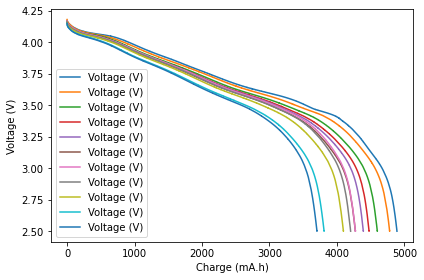

In [4]:
# Plot of the discharge voltage curves for the 3 datasets being analysed
fig_V_curves, ax = plt.subplots()


for cell in cellData_A:
    data_to_plot = cell[cell['Current (mA)'] < 0]
    data_to_plot.plot('Charge (mA.h)', 'Voltage (V)', ax=ax, )

ax.set_ylabel('Voltage (V)')

fig_V_curves.tight_layout()

# This is the shortest verison of DMA, just want to show

In [5]:
discharge_cellBOL = cellData_A[0].copy()
discharge_cellBOL = discharge_cellBOL[
    discharge_cellBOL[
    'Current (mA)']<0].loc[
    :, ['Charge (mA.h)', 'Voltage (V)']]
discharge_cellBOL.reset_index(inplace=True, drop=True)
discharge_cellBOL['SOC (%)'] =(
    1 - 
    discharge_cellBOL['Charge (mA.h)']
    /discharge_cellBOL['Charge (mA.h)'].max()   )
Guess_Values = [
    [0.1, 0.002, 0.95, 0.85, 0.84],
    [0.05, 0.02, 0.93, 0.82, 0.84],
    [0.1, 0.08, 0.93, 0.80, 0.84],
    [0.09, 0.002, 0.96, 0.86, 0.84],
    [0.11, 0.01, 0.95, 0.86, 0.84],
]
""" 
init_PE_lo = 0.1
init_NE_lo = 0.01
init_PE_hi = 0.98
init_NE_hi = 0.88 """
for guess_values in Guess_Values:
    composite_fitted_params, _, _ = dmc.stoich_OCV_fit_multi_comp(
        NE_Gr_OCV, NE_Si_OCV, PE_OCV, discharge_cellBOL,
        z_guess=guess_values)
    comp_cell_curve, _, _, _ = dmc.calc_full_cell_OCV_multi_standalone(
        NE_Gr_OCV, NE_Si_OCV, PE_OCV, discharge_cellBOL['SOC (%)'], 
        *composite_fitted_params)
    fitted_Gr_fract = composite_fitted_params[4].round(4)
    fitted_Si_fract = 1-fitted_Gr_fract
    err_BoL = dmc.DM_error_check(
        NE_Gr_OCV, NE_Si_OCV, PE_OCV, discharge_cellBOL, 
        composite_fitted_params)
    print(f"RMSE for {guess_values} is {(err_BoL*1e3).round(2)} mV")

RMSE for [0.1, 0.002, 0.95, 0.85, 0.84] is 13.95 mV
RMSE for [0.05, 0.02, 0.93, 0.82, 0.84] is 16.09 mV
RMSE for [0.1, 0.08, 0.93, 0.8, 0.84] is 8.53 mV
RMSE for [0.09, 0.002, 0.96, 0.86, 0.84] is 10.21 mV
RMSE for [0.11, 0.01, 0.95, 0.86, 0.84] is 8.81 mV


In [6]:
discharge_cellBOL = cellData_A[1].copy()
discharge_cellBOL = discharge_cellBOL[
    discharge_cellBOL[
    'Current (mA)']<0].loc[
    :, ['Charge (mA.h)', 'Voltage (V)']]
discharge_cellBOL.reset_index(inplace=True, drop=True)
discharge_cellBOL['SOC (%)'] =(
    1 - 
    discharge_cellBOL['Charge (mA.h)']
    /discharge_cellBOL['Charge (mA.h)'].max()   )
Guess_Values = [
    [0.1, 0.002, 0.95, 0.85, 0.84],
    [0.05, 0.02, 0.93, 0.82, 0.84],
    [0.1, 0.08, 0.93, 0.80, 0.84],
    [0.09, 0.002, 0.96, 0.86, 0.84],
    [0.11, 0.01, 0.95, 0.86, 0.84],
]
""" 
init_PE_lo = 0.1
init_NE_lo = 0.01
init_PE_hi = 0.98
init_NE_hi = 0.88 """
for guess_values in Guess_Values:
    composite_fitted_params, _, _ = dmc.stoich_OCV_fit_multi_comp(
        NE_Gr_OCV, NE_Si_OCV, PE_OCV, discharge_cellBOL,
        z_guess=guess_values)
    comp_cell_curve, _, _, _ = dmc.calc_full_cell_OCV_multi_standalone(
        NE_Gr_OCV, NE_Si_OCV, PE_OCV, discharge_cellBOL['SOC (%)'], 
        *composite_fitted_params)
    fitted_Gr_fract = composite_fitted_params[4].round(4)
    fitted_Si_fract = 1-fitted_Gr_fract
    err_BoL = dmc.DM_error_check(
        NE_Gr_OCV, NE_Si_OCV, PE_OCV, discharge_cellBOL, 
        composite_fitted_params)
    print(f"RMSE for {guess_values} is {(err_BoL*1e3).round(2)} mV")

RMSE for [0.1, 0.002, 0.95, 0.85, 0.84] is 24.8 mV
RMSE for [0.05, 0.02, 0.93, 0.82, 0.84] is 14.26 mV
RMSE for [0.1, 0.08, 0.93, 0.8, 0.84] is 12.74 mV
RMSE for [0.09, 0.002, 0.96, 0.86, 0.84] is 18.95 mV
RMSE for [0.11, 0.01, 0.95, 0.86, 0.84] is 7.55 mV


In [7]:
print(np.power(5,5))

3125


Text(0.35, 0.2, 'Gr_fraction: 0.8421\nSi_fraction: 0.1579')

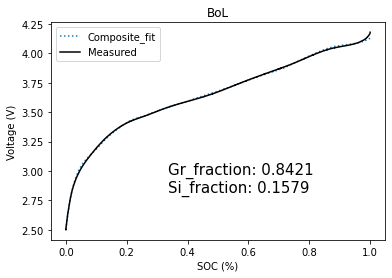

In [8]:
ax = comp_cell_curve.plot(
    'SOC (%)', 'OCV',  label='Composite_fit', ls=':')
discharge_cellBOL.plot(
    'SOC (%)', 'Voltage (V)', ax=ax, label='Measured', c='k')
ax.set_title('BoL')
ax.set_ylabel('Voltage (V)')
ax.annotate(f'Gr_fraction: {fitted_Gr_fract.round(4)}\nSi_fraction: {fitted_Si_fract.round(4)}',
    xy=(0.35,0.2), xycoords='axes fraction',
    xytext=(0.35,0.2), textcoords='axes fraction', 
    horizontalalignment='left',
    verticalalignment='bottom', fontsize=15)

In [ ]:
# Analayse the 3 datasets using the DMA function
DM_data, stoic_data, error_data = dmc.DM_calc_multi_comp_long(
    NE_Gr_OCV, NE_Si_OCV, PE_OCV, cellData_A[0], cellData_A[1:])
# Inspect one of the output DataFrames
error_data.head()

0
1
2
3



iter_val=0  
while (
    aged_params[4] > param_list[counter_val][4]   # corresponds to Si_cap
    or 
    aged_params[2] > param_list[counter_val][2]) #  corresponds to ano_tot_cap
and iter_val < 10:  # repeat for 10 times！
    iter_val += 1
    z_EoL, z_EoL_cov, aged_params = stoich_OCV_fit_multi_comp(
        anode_comp1_data=neg_el_comp1, 
        anode_comp2_data=neg_el_comp2, cathode_data=pos_el, 
        full_cell=aged_cell_data, 
        z_guess=z_list[counter_val], 
        diff_step_size=0.1)
    # Calculate error of fit (RMSE of fitted curve minus actual data)
    err_EoL = DM_error_check(
        neg_el_comp1, neg_el_comp2, 
        pos_el, aged_cell_data, z_EoL)

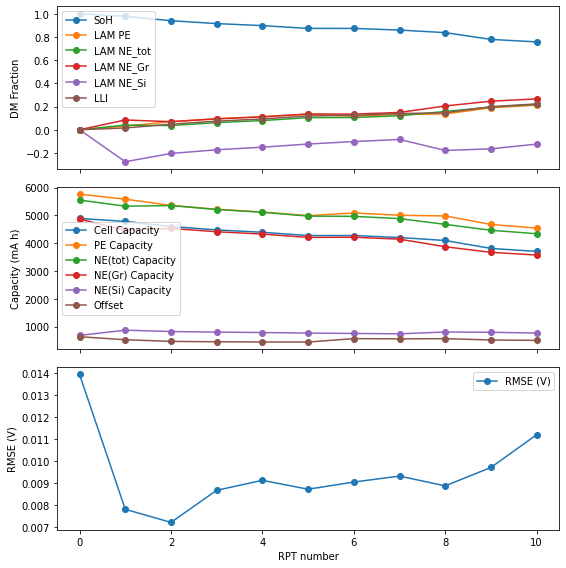

In [12]:
# Plot the output data from the DMA function
fig_DMA_output, ax = plt.subplots(3,1, sharex=True, figsize=(8,8))

DM_data.plot(ax=ax[0], marker='o')
stoic_data.plot(ax=ax[1], marker='o')
error_data.plot(ax=ax[2], marker='o')

ax[0].set_ylabel('DM Fraction')
ax[1].set_ylabel('Capacity (mA h)')
ax[2].set_ylabel('RMSE (V)')
ax[2].set_xlabel('RPT number')

fig_DMA_output.tight_layout()

In [11]:
# One figure for one RPT of one cell; therefore 9 cells; each cell has 13 RPT max; 
# total figure will be: 13*9=117 
# in each figure: sub-plot-1 for voltage fit for the best; 
#                 sub-plot-2 Dataset-number-RMSE
# another 3 plots same as Niall, but with one more plot for all voltage (best fit)
# functions to use: 
# 1-DM_calc_multi_comp_long             
# 2-stoich_OCV_fit_multi_comp 
# 3-calc_full_cell_OCV_multi_standalone 
# 4-DM_error_check (this round plus Niall's old version)
